# 制約付きMDPでの探索と活用

参考

* [Exploration-Exploitation in Constrained MDPs](https://arxiv.org/abs/2003.02189)

強化学習では累積報酬和を最大化するような方策を学習することが目標ですが、実際のアプリケーションでは方策の挙動に対して何らかの制約が求められる場合があります。
制約付きMDP（CMDP）では制約を満たしながらの累積報酬和の最大化が求められるわけですが、この状況での探索はどうすればよいでしょうか？


表記

* 有限MDP: $\mathcal{M}=\left(\mathcal{S}, \mathcal{A}, c, p, s_1, H\right)$
    1. 有限状態集合: $S=\{1, \dots, |S|\}$
    2. 有限行動集合: $A=\{1, \dots, |A|\}$
    3. 非定常なコスト関数（元論文では確率変数ですが、ややこしいので決定的にします）: $c_h(s, a)$
    4. 非定常遷移確率: $p_h(s'|s, a)$
    5. 初期状態: $s_1$
    6. ホライゾン: $H$
    7. すべての状態行動の中で最大の次状態への遷移の数: $\mathcal{N}:=\max _{s, a, h}\left|\left\{s^{\prime}: p_h\left(s^{\prime} \mid s, a\right)>0\right\}\right|$
* 占有率：$q_h^\pi(s, a ; p):=\mathbb{E}\left[\mathbb{1}\left\{s_h=s, a_h=a\right\} \mid s_1=s_1, p, \pi\right]=\operatorname{Pr}\left\{s_h=s, a_h=a \mid s_1=s_1, p, \pi\right\}$
* 価値関数：$V_1^\pi\left(s_1 ; p, c\right)=\sum_{h, s, a} q_h^\pi(s, a ; p) c_h(s, a):=c^T q^\pi(p)$

これは次の式で導出可能
$$
\begin{aligned}
& \mathbb{E}\left[\sum_{h=1}^H c_h\left(s_h, a_h\right) \mid s_1=s_1, \pi, p\right]=\sum_{h=1}^H \mathbb{E}\left[c_h\left(s_h, a_h\right) \mid s_1=s_1, \pi, p\right] \\
& =\sum_{h=1}^H \sum_{s, a} c_h(s, a) \operatorname{Pr}\left\{s_h=s, a_h=a \mid s_1=s_1, p, \pi\right\} \\
& \sum_{h=1}^H \sum_{s, a} c_h(s, a) q_h^\pi(s, a ; p)=c^T q^\pi(p),
\end{aligned}
$$


## 有限ホライゾンConstrained MDP

* $\{d_i, \alpha_i\}_{i=1}^I$：$I$個の制約
    * $d_i \in \mathbb{R}^{SAH}$
    * $\alpha_i \in [0, H]$
    * $i$番目の制約（元論文では確率変数ですが、ややこしいので決定的にします）$d_{i, h}(s, a)$
    * $V_h^\pi\left(s ; p, d_i\right):=\mathbb{E}\left[\sum_{h^{\prime}=h}^H d_{i, h^{\prime}}\left(s_{h^{\prime}}, a_{h^{\prime}}\right) \mid s_h=s, p, \pi\right]$.

CMDPの目的は次の最適方策の導出です。

$$
\begin{gathered}
\pi^{\star} \in \underset{\pi \in \Pi^{\mathrm{MR}}}{\arg \min } c^T q^\pi(p) \\
\text { s.t. } D q^\pi(p) \leq \alpha
\end{gathered}
$$

ここで、
$$
D=\left[\begin{array}{c}
d_1^T \\
\vdots \\
d_I^T
\end{array}\right], \quad \alpha=\left[\begin{array}{c}
\alpha_1 \\
\vdots \\
\alpha_I
\end{array}\right]
$$

以下では最適方策が方策集合の中にあることを仮定します（Feasibility）。

また、最適方策は決定的でない可能性があることに注意しましょう。制約のせいで、通常のMDPで成り立つ性質がCMDPでも成り立つかは自明ではありません。

CMDPの性能を測るために、次のリグレットを考えます。

$$
\begin{aligned}
& \operatorname{Reg}_{+}(K ; c)=\sum_{k=1}^K\left[V_1^{\pi_k}\left(s_1 ; p, c\right)-V_1^{\star}\left(s_1\right)\right]_{+} \\
& \operatorname{Reg}_{+}(K ; d)=\max _{i \in[I]} \sum_{k=1}^K\left[V_1^{\pi_k}\left(s_1 ; p, d_i\right)-\alpha_i\right]_{+},
\end{aligned}
$$

こっちのリグレットを考えると大変なので、次のリグレットを考えることもあります。

$$
\begin{aligned}
& \operatorname{Reg}(K ; c)=\sum_{k=1} V_1^{\pi_k}\left(s_1 ; p, c\right)-V_1^{\star}\left(s_1\right) \\
& \operatorname{Reg}(K ; d)=\max _{i \in[I]}\left[\sum_{k=1}^K V_1^{\pi_k}\left(s_1 ; p, d_i\right)-\alpha_i\right]
\end{aligned}
$$

これは上で定義した$\operatorname{Reg}_+$のほうが強い制約であることに注意しましょう。下のリグレットでは、負と正のviolation同士が打ち消し合うことがあります。

## CMDPでの線型計画法

まず、任意の方策について占有率は次の方程式を満たします。

$$
\begin{aligned}
\sum_a q_h^\pi(s, a) & =\sum_{s^{\prime}, a^{\prime}} p_{h-1}\left(s \mid s^{\prime}, a^{\prime}\right) q_{h-1}^\pi\left(s^{\prime}, a^{\prime}\right) & & \forall s \in \mathcal{S} \\
q_h^\pi(s, a) & \geq 0 & & \forall s, a
\end{aligned}
$$

この方程式を満たす$q^\pi$は確率測度であることに注意しましょう。
確率測度全体の集合を$\Delta^\mu(\mathcal{M})$とします。（これは凸集合になります。６ページの参考文献参照。）

線型計画法の解で得られた占有率を使って方策を表すことができます。

$$
\pi_h^q(a \mid s)=\frac{q_h(s, a)}{\sum_b q_h(s, b)}, \quad \forall(s, a, h) \in \mathcal{S} \times \mathcal{A} \times[H]
$$

これを使うと、CMDPの問題は次の問題と等価になります。

$$
\begin{array}{lll}
& \min _q \sum_{s, a, h} q_h(s, a) c_h(s, a) & \\
\text { s.t. } & \sum_{s, a, h} q_h(s, a) d_{i, h}(s, a) \leq \alpha_i & \forall i \in[I]\\
& \sum_a q_h(s, a)=\sum_{s^{\prime}, a^{\prime}} p_{h-1}\left(s \mid s^{\prime}, a^{\prime}\right) q_{h-1}\left(s^{\prime}, a^{\prime}\right) & \forall h \in[H] \backslash\{1\}\\
& \sum_a q_1(s, a)=\mu(s) & \forall s \in \mathcal{S} \\
& q_h(s, a) \geq 0 & \forall(s, a, h) \in \mathcal{S} \times \mathcal{A} \times[H]
\end{array}
$$

**その他の表記**

任意の確率変数$X$について、

$$\mathbb{E}\left[X\left(s_h^k, a_h^k\right) \mid \mathcal{F}_{k-1}\right]=\sum_{s, a} q_h^{\pi_k}(s, a ; p) X(s, a)$$

が成り立つことに注意しましょう。

* $\widetilde{O}(X)$は$X$に対数多項式的に依存する量とします
* $\lesssim$は対数多項式を無視した$\leq$とします。


## CMDPでのUCRLアルゴリズム（OPTCMDP）

まずはCMDP版のUCRL2アルゴリズムであるOptCMDPを見てみましょう。

* $k$エピソード以前に訪れた状態行動の数：$n_h^{k-1}(s, a)=\sum_{k^{\prime}=1}^{k-1} \mathbb{1}\left(s_h^{k^{\prime}}=s, a_h^{k^{\prime}}=a\right)$
* これを使った経験平均値

$$
\begin{aligned}
\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right) & =\frac{\sum_{k^{\prime}=1}^{k-1} \mathbb{1}\left(s_h^{k^{\prime}}=s, a_h^{k^{\prime}}=a, s_{h+1}^{k^{\prime}}=s^{\prime}\right)}{n_h^{k-1}(s, a) \vee 1} \\
\end{aligned}
$$

まず、OptCMDPはUCRLみたいに信頼集合を構築します。

$$
\begin{aligned}
B_{h, k}^p(s, a) & =\left\{\widetilde{p}(\cdot \mid s, a) \in \Delta_S: \forall s^{\prime} \in \mathcal{S},\left|\widetilde{p}(\cdot \mid s, a)-\bar{p}_h^{k-1}(\cdot \mid s, a)\right| \leq \beta_{h, k}^p\left(s, a, s^{\prime}\right)\right\}
\end{aligned}
$$

ここで、その範囲$\beta$は

$$\beta_{h, k}^p\left(s, a, s^{\prime}\right):=2 \sqrt{\frac{\operatorname{Var}\left(\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right) L_\delta^p}{n_h^{k-1}(s, a) \vee 1}}+\frac{14 / 3 L_\delta^p}{n_h^{k-1}(s, a) \vee 1}$$

によって構築します。
ここで、$\operatorname{Var}\left(\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right)=\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right) \cdot\left(1-\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right)$です。（Bernsteinを使ったUCRLでも似たような項が出てきます。）
また、$L_\delta^p=\ln \left(\frac{6 S A H K}{\delta}\right)$です。

この信頼集合を使って、
$$
\mathcal{M}_k=\left\{M=(\mathcal{S}, \mathcal{A}, c, d, \widetilde{p}): \widetilde{p}_h(\cdot \mid s, a) \in B_{h, k}^p(s, a)\right\}
$$

を定義します。
信頼集合が定義されたら、次の最適化問題を解くことで方策を更新します。

$$
\begin{aligned}
\min _{\widetilde{p} \in B_k^p, \pi \in \Pi^{\mathrm{MR}}} & \sum_{h, s, a} {c}_h(s, a) q_h^\pi(s, a ; \widetilde{p}) \\
\text { s.t. } & \sum_{h, s, a} {d}_{i, h}(s, a) q_h^\pi(s, a ; \widetilde{p}) \leq \alpha_i, \quad \forall i \in[H]
\end{aligned}
$$


この問題で得られる方策を$\pi_k$とし、得られるMDPを

$$
\widetilde{M}_k=\left(\mathcal{S}, \mathcal{A}, {c}_k, {d}_k, \widetilde{p}_k\right)
$$

とします。このとき、方策は

$$
V_1^{\pi_k}\left(s_1 ; {c}_k, {p}_k\right):={c}_k^{\top} q^{\pi_k}\left(\widetilde{p}_k\right) \leq c^{\top} q^{\pi^{\star}}(p):=V_1^{\star}\left(s_1 ; c, p\right)
$$

の意味で楽観的になっています。

これを証明しましょう。



### ステップ１：Good eventの定義

まず、Failure eventを定義します。

$$
\begin{aligned}
& F_k^p=\left\{\exists s, a, s^{\prime}, h:\left|p_h\left(s^{\prime} \mid s, a\right)-\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right| \geq \beta_{h, k}^p\left(s, a, s^{\prime}\right)\right\} \\
& F_k^N=\left\{\exists s, a, h: n_h^{k-1}(s, a) \leq \frac{1}{2} \sum_{j<k} q_h^{\pi_k}(s, a \mid p)-H \ln \frac{S A H}{\delta^{\prime}}\right\}
\end{aligned}
$$

また、$F^P=\bigcup_{k=1}^K F_k^p$とします。
つまり、

* $F^p_k$：$k$エピソード目で、遷移確率が推定値から大幅にずれているイベント。証明は[Learning Adversarial MDPs with Bandit Feedback and Unknown Transition](https://arxiv.org/abs/1912.01192)参照。
* $F^p$：$K$エピソード目までに一度でも推定値が大幅にずれているイベント。
* $F^N_k$：全然訪れていない$(s, a)$があるイベント。証明は[Unifying pac and regret: Uniform pac bounds for episodic reinforcement learning](https://arxiv.org/abs/1703.07710)参照。

このとき、
$$
\begin{aligned}
&\operatorname{Pr}\left\{\left|p_h\left(s^{\prime} \mid s, a\right)-\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right| \geq \epsilon_1\right\} \leq \delta^{\prime \prime}\\
&\epsilon_1=\sqrt{\frac{2 \operatorname{Var}\left(\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right) \ln \left(\frac{2}{\delta^{\prime \prime}}\right)}{n_h^{k-1}(s, a) \vee 1}}+\frac{7 \ln \left(\frac{2}{\delta^{\prime \prime}}\right)}{3\left(n_h^{k-1}(s, a)-1\right) \vee 1} .
\end{aligned}
$$
が成立します。また、
$$
\begin{aligned}
&\operatorname{Pr}\left\{\left|p_h\left(s^{\prime} \mid s, a\right)-\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right| \geq \epsilon_2\right\} \leq \delta^{\prime \prime}\\
&\epsilon_2=\sqrt{\frac{2 \operatorname{Var}\left(\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)\right) \ln \left(\frac{2}{\delta^{\prime \prime}}\right)}{n_h^{k-1}(s, a) \vee 1}}+\frac{7 \ln \left(\frac{2}{\delta^{\prime \prime}}\right)}{3\left(n_h^{k-1}(s, a)-1 \vee 1\right)}
\end{aligned}
$$
も成り立ちます。$\epsilon_1 \leq \epsilon_2$なので。

$\delta^{\prime \prime}=\frac{\delta^{\prime}}{(S A H K)^2}$としてUnion Boundをとれば、$\operatorname{Pr}\left\{F^P\right\} \leq \delta^{\prime}$が成り立ちます。


以上のFailure Eventに対して、

$\bar{G}=F^p \bigcup F^N$としてGood eventを定義します。
このGood Eventが成り立っているとき、

$$
\left|\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)-p_h\left(s^{\prime} \mid s, a\right)\right|=C_1 \sqrt{\frac{p_h\left(s^{\prime} \mid s, a\right) L_{\delta, p}}{n_h^k(s, a) \vee 1}}+\frac{C_2 L_{\delta, p}}{n_h^k(s, a) \vee 1}
$$

となる定数$C_1, C_2 > 0$が存在します。ここで$L_{\delta, p}=\ln \left(\frac{6 S A H K}{\delta}\right)$です。


### ステップ２：最適方策が$k$エピソード目で実行可能であることの証明

まず、
$$
\begin{gathered}
\pi^{\star} \in \underset{\pi \in \Pi^{\mathrm{MR}}}{\arg \min } c^T q^\pi(p) \\
\text { s.t. } D q^\pi(p) \leq \alpha
\end{gathered}
$$
と
$$
\begin{aligned}
\min _{\widetilde{p} \in B_k^p, \pi \in \Pi^{\mathrm{MR}}} & \sum_{h, s, a} {c}_h(s, a) q_h^\pi(s, a ; \widetilde{p}) \\
\text { s.t. } & \sum_{h, s, a} {d}_{i, h}(s, a) q_h^\pi(s, a ; \widetilde{p}) \leq \alpha_i, \quad \forall i \in[H]
\end{aligned}
$$
であることを思い出しましょう。また、Good eventが成立しているとき、真のモデル$p$は$B^p_k$の中に入ってることに注意しましょう。
すると、明らかに$\pi^*$は任意の$k$について実行可能です。

（元論文の証明はちょっとよくわかんなかったです。$B$の中のすべての$p'$について制約を満たすようにすると必ずしも実行可能にならなさそうです。）


### ステップ３：楽観的な方策の証明

* $\Pi_D=\left\{\pi: D q^\pi(p) \leq \alpha\right\}$を制約を満たす方策の集合
* $\Pi_D^k=\left\{\pi: {D} q^\pi\left(p^{\prime}\right) \leq \alpha,\; \exists p^{\prime} \in B_k^p\right\}$ を何らかの$p'$に対して制約を満たすような方策の集合（$\pi^\star \in \Pi_D^k$であることに注意しましょう）

Good eventのとき、

$$
V_1^{\pi_k}\left(s_1 ; {c}, \widetilde{p}_k\right) \leq V_1^{\star}\left(s_1\right)
$$

および

$$
V_1^{\pi_k}\left(s_1 ; {c}, \widetilde{p}_k\right) \leq V_1^{\pi_k}\left(s_1 ; c, p\right)
$$

であることを示しましょう。

$$
\begin{aligned}
V^{\pi_k}\left(s_1; c, p\right)
& \geq \min _{\pi \in \Delta_A^S}\left\{c^T q^\pi(p) \mid \pi \in \Pi_D\right\} 
= V^*\left(s_1\right)\\
& \geq \min _{\pi \in \Delta_A^S, p^{\prime} \in B_k^p}\left\{c^T q^\pi(p') \mid \pi \in \Pi_D^k\right\} \\
& =\min _{\pi \in \Delta_A^S, p^{\prime} \in B_k^p}\left\{c^T q^\pi(p') \mid {D} q^\pi\left(p^{\prime}\right) \leq \alpha\right\} 
=V_1^{\pi_k}\left(s_1 ; {c}, \widetilde{p}_k\right)
\end{aligned}
$$

なので、両方成立します。

## 拡張線形計画問題

OptCMDPは次の問題を解くことを思い出しましょう。

$$
\begin{aligned}
\min _{\widetilde{p} \in B_k^p, \pi \in \Pi^{\mathrm{MR}}} & \sum_{h, s, a} {c}_h(s, a) q_h^\pi(s, a ; \widetilde{p}) \\
\text { s.t. } & \sum_{h, s, a} {d}_{i, h}(s, a) q_h^\pi(s, a ; \widetilde{p}) \leq \alpha_i, \quad \forall i \in[H]
\end{aligned}
$$

一方で、これはダイレクトに解くことはできません（目的変数が２つあるせい？）。

そこで、

$$z_h^\pi\left(s, a, s^{\prime} ; p\right)=p_h\left(s^{\prime} \mid s, a\right) q_h^\pi(s, a ; p)$$

で定義される変数に対する拡張線形計画問題を解きます。
$$
\begin{array}{lll}
\min _z \sum_{h, s, a, s^{\prime}} z_h\left(s, a, s^{\prime}\right) c_h(s, a) & \\
\text { s.t. } \sum_{h, s, a, s^{\prime}} z_h\left(s, a, s^{\prime}\right) d_{i, h}(s, a) \leq \alpha_i & \forall i \in[I]\\
\sum_{a, s^{\prime}} z_h\left(s, a, s^{\prime}\right)=\sum_{s^{\prime}, a^{\prime}} z_{h-1}\left(s^{\prime}, a^{\prime}, s\right) & \forall h \in[H] \backslash\{1\} \\
\sum_{a, s^{\prime}} z_1\left(s, a, s^{\prime}\right)=\mu(s) & \forall s \in \mathcal{S}\\
z_h\left(s, a, s^{\prime}\right) \geq 0 & \forall\left(s, a, s^{\prime}, h\right) \in \mathcal{S} \times \mathcal{A} \times \mathcal{S} \times[H] \\
z_h\left(s, a, s^{\prime}\right)-\left(\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)+\beta_{h, k}^p\left(s, a, s^{\prime}\right)\right) \sum_y z_h(s, a, y) \leq 0 & \forall\left(s, a, s^{\prime}, h\right) \in \mathcal{S} \times \mathcal{A} \times \mathcal{S} \times[H] \\
-z_h\left(s, a, s^{\prime}\right)+\left(\bar{p}_h^{k-1}\left(s^{\prime} \mid s, a\right)-\beta_{h, k}^p\left(s, a, s^{\prime}\right)\right) \sum_y z_h(s, a, y) \leq 0 & \forall\left(s, a, s^{\prime}, h\right) \in \mathcal{S} \times \mathcal{A} \times \mathcal{S} \times[H]
\end{array}
$$

この解の$z$を次のようにすれば最適解が得られます。
$$\widetilde{p}_h^k\left(s^{\prime} \mid s, a\right)=\frac{z\left(s, a, s^{\prime}\right)}{\sum_y z(s, a, y)} \quad \text{and} \quad \pi_k(a \mid s)=\frac{\sum_{s^{\prime}} z\left(s, a, s^{\prime}\right)}{\sum_{b, s^{\prime}} z\left(s, b, s^{\prime}\right)}$$

このOptCMDPのリグレットを導出しましょう。

$\delta\in (0, 1)$とします。このとき、$K'\in [K]$について、確率$1-\delta$以上で、

$$
\begin{aligned}
& \operatorname{Reg}_{+}\left(K^{\prime} ; c\right) \leq \widetilde{\mathcal{O}}\left(\sqrt{S \mathcal{N} H^4 K}+(\sqrt{\mathcal{N}}+H) H^2 S A\right), \\
& \operatorname{Reg}_{+}\left(K^{\prime} ; d\right) \leq \widetilde{\mathcal{O}}\left(\sqrt{S \mathcal{N} H^4 K}+(\sqrt{\mathcal{N}}+H) H^2 S A\right) .
\end{aligned}
$$

が成り立ちます。証明しましょう。

まず、確率$1-\delta$以上でGood Eventが成立します（Good event参照）。
このとき、

$$
\begin{aligned}
\text { Regret }^{+}\left(K^{\prime} ; c\right) & =\sum_k\left[V_1^{\pi_k}\left(s_1 ; c, p\right)-V_1^*\left(s_1 ; c, p\right)\right]_{+} \leq \sum_k\left[V_1^{\pi_k}\left(s_1 ; c, p\right)-V_1^{\pi_k}\left(s_1 ; \widetilde{c}_k, \widetilde{p}_k\right)\right]_{+} \\
& =\sum_k V_1^{\pi_k}\left(s_1 ; c, p\right)-V_1^{\pi_k}\left(s_1 ; \widetilde{c}_k, \widetilde{p}_k\right) \\
& \leq \widetilde{\mathcal{O}}\left(\sqrt{S \mathcal{N} H^4 K}+(\sqrt{\mathcal{N}}+H) H^2 S A\right) .
\end{aligned}
$$

が成り立ちます。
ここで、最初の不等式と２つ目の等式は楽観的方策のおかげです。最後の不等式はAppendix Eを参照してください。（TODO: Appendix Eは何かと便利そうなのでまとめておこう。）

続いて制約違反のリグレットを導出します。
これも似たような変形でできます。
$$
\begin{aligned}
\sum_{k=1}^{K^{\prime}}\left[V_1^{\pi_k}\left(s_1 ; d_i, p\right)-\alpha_i\right]_{+} & =\sum_{k=1}^{K^{\prime}}[\underbrace{V_1^{\pi_k}\left(s_1 ; d_i, p\right)-V_1^{\pi_k}\left(s_1 ; \widetilde{d}_i^k, \tilde{p}^k\right)}_{\geq 0}+\underbrace{V_1^{\pi_k}\left(s_1 ; \tilde{d}_i^k, \tilde{p}^k\right)-\alpha_i}_{\leq 0}]_{+} \\
& \leq \sum_{k=1}^{K^{\prime}} V_1^{\pi_k}\left(s_1 ; d_i\right)-V_1^{\pi_k}\left(s_1 ; \tilde{d}_i^k, \widetilde{p}^k\right) \\
& \leq \widetilde{\mathcal{O}}\left(\sqrt{S \mathcal{N} H^4 K}+(\sqrt{\mathcal{N}}+H) H^2 S A\right) .
\end{aligned}
$$


PythonでOptCMDPを実装してみます。

In [37]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Optional
from jax.random import PRNGKey

key = PRNGKey(0)

S = 7  # 状態集合のサイズ
A = 3  # 行動集合のサイズ
S_set = jnp.arange(S)  # 状態集合
A_set = jnp.arange(A)  # 行動集合
H = 5  # ホライゾン

# 報酬行列を適当に作ります
key, _ = jax.random.split(key)
rew = jax.random.uniform(key=key, shape=(H, S, A))
assert rew.shape == (H, S, A)


# コスト行列を適当に作ります
key, _ = jax.random.split(key)
cost = jax.random.uniform(key=key, shape=(H, S, A))
assert cost.shape == (H, S, A)


# 遷移確率行列を適当に作ります
key, _ = jax.random.split(key)
P = jax.random.uniform(key=key, shape=(H, S*A, S))
P = P / jnp.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
P = P.reshape(H, S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 初期状態分布を適当に作ります
key, _ = jax.random.split(key)
init_dist = jax.random.uniform(key, shape=(S,))
init_dist = init_dist / jnp.sum(init_dist)
np.testing.assert_allclose(init_dist.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります

class CMDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    H: int  # ホライゾン
    rew: jnp.array  # 報酬行列
    cost: jnp.array  # 報酬行列
    const: float  # 制約の閾値
    P: jnp.array  # 遷移確率行列
    init_dist: jnp.array  # 初期分布
    optimal_V_rew: Optional[jnp.ndarray] = None  # 報酬についての最適V値
    optimal_V_cost: Optional[jnp.ndarray] = None  # コストについての最適V値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


const = 0.3 * H  # 制約は適当です。このときに実行可能である保証はとくにありません。
mdp = CMDP(S_set, A_set, H, rew, cost, const, P, init_dist)

print("状態数：", mdp.S)
print("行動数：", mdp.A)
print("ホライゾン：", mdp.H)
print("制約：", mdp.const)

状態数： 7
行動数： 3
ホライゾン： 5
制約： 1.5


In [38]:
from functools import partial
import jax
import chex


@jax.jit
def compute_policy_Q(mdp: CMDP, policy: jnp.ndarray):
    """ベルマン期待作用素をホライゾン回走らせて価値関数を動的計画法で計算します。
    Args:
        mdp (CMDP)
        policy (np.ndarray): (HxSxA)の行列

    Returns:
        policy_Q_rew (jnp.ndarray): (HxSxA)の行列. 報酬関数についてのQ
        policy_Q_cost (jnp.ndarray): (HxSxA)の行列. コスト関数についてのQ
    """
    H, S, A = policy.shape

    def backup(i, args):
        policy_Q, g = args
        h = H - i - 1
        max_Q = (policy[h+1] * policy_Q[h+1]).sum(axis=1)
        next_v = mdp.P[h] @ max_Q
        chex.assert_shape(next_v, (S, A))
        policy_Q = policy_Q.at[h].set(g[h] + next_v)
        return policy_Q, g
    
    policy_Q_rew = jnp.zeros((H+1, S, A))
    args = policy_Q_rew, mdp.rew
    policy_Q_rew, _ = jax.lax.fori_loop(0, mdp.H, backup, args)

    policy_Q_cost = jnp.zeros((H+1, S, A))
    args = policy_Q_cost, mdp.cost
    policy_Q_cost, _ = jax.lax.fori_loop(0, mdp.H, backup, args)
    return policy_Q_rew[:-1], policy_Q_cost[:-1]


uni_policy = jnp.ones((H, S, A)) / A
_ = compute_policy_Q(mdp, uni_policy)

まずは探索無しで、CMDPの最適方策を求めてみます

In [39]:
import pulp
from itertools import product
prob = pulp.LpProblem(name="CMDP", sense=pulp.LpMaximize)
hsa_indices = [(h, s, a) for h, s, a in product(range(H), range(S), range(A))]
sa_indices = [(s, a) for s, a in product(range(S), range(A))]
d = pulp.LpVariable.dicts("d", hsa_indices, lowBound=0, cat="Continuous")

# 目的関数
prob += pulp.lpSum([d[hsa] * mdp.rew[hsa[0], hsa[1], hsa[2]] for hsa in hsa_indices])

# 初期状態についての制約
for s in range(S):
    d_0sa = [d[(0, s, a)] for a in range(A)]
    prob += pulp.lpSum(d_0sa) == mdp.init_dist[s].item()

# 各ステップについての制約
for h in range(1, H):
    for ns in range(S):
        d_hns = pulp.lpSum([d[(h, ns, na)] for na in range(A)])
        d_phns = pulp.lpSum([d[(h-1, sa[0], sa[1])] * mdp.P[h-1, sa[0], sa[1], ns] for sa in sa_indices])
        prob += d_hns == d_phns

# CMDPとしての制約
const = pulp.lpSum([d[hsa] * mdp.cost[hsa[0], hsa[1], hsa[2]] for hsa in hsa_indices]) <= mdp.const
prob += const


sol = prob.solve()
d_arr = jnp.array([pulp.value(d[h, s, a]) for (h, s, a) in hsa_indices])
d_arr = d_arr.reshape(H, S, A)

np.testing.assert_allclose(d_arr.sum(axis=(1, 2)), 1.0, atol=1e-4)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/toshinori/.cache/pypoetry/virtualenvs/shumi-VTLwuKSy-py3.9/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/7579ec0b05154170a7dd862d839842ce-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/7579ec0b05154170a7dd862d839842ce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 41 COLUMNS
At line 945 RHS
At line 982 BOUNDS
At line 983 ENDATA
Problem MODEL has 36 rows, 105 columns and 798 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 36 (0) rows, 105 (0) columns and 798 (0) elements
0  Obj -0 Primal inf 3.1304663 (7) Dual inf 55.918695 (105)
0  Obj -0 Primal inf 3.1304663 (7) Dual inf 8.0607626e+11 (105)
31  Obj 1.46577 Primal inf 0.96128205 (4) Dual inf 3.4048413e+11 (38)
50  Obj 3.2056036
Optimal - objective value 3.2056036
Optimal objective 3.205603601 - 50 iterations tim

In [40]:
optimal_policy = d_arr / d_arr.sum(axis=-1, keepdims=True)
Q_rew, Q_cost = compute_policy_Q(mdp, optimal_policy)
V_rew, V_cost = (Q_rew * optimal_policy).sum(axis=-1), (Q_cost * optimal_policy).sum(axis=-1)

total_cost = V_cost[0] @ mdp.init_dist
assert total_cost <= mdp.const
print("最適方策の累積コスト和", total_cost)

total_rew = V_rew[0] @ mdp.init_dist
print("最適方策の累積報酬和", total_rew)

mdp = mdp._replace(optimal_V_rew=V_rew, optimal_V_cost=V_cost)

最適方策の累積コスト和 1.5
最適方策の累積報酬和 3.2056034


In [41]:
uniform_policy = jnp.ones((H, S, A)) / A
Q_rew, Q_cost = compute_policy_Q(mdp, uniform_policy)

total_cost = (Q_cost * uniform_policy)[0].sum(axis=-1) @ mdp.init_dist
print("一様方策の累積コスト和", total_cost)

total_rew = (Q_rew * uniform_policy)[0].sum(axis=-1) @ mdp.init_dist
print("一様方策の累積報酬和", total_rew)


一様方策の累積コスト和 2.467288
一様方策の累積報酬和 2.3794038


最適方策は計算できました。OptCMDPを実装しましょう。

In [42]:
from jax.random import PRNGKey
from functools import partial


@partial(jax.jit, static_argnames=("N",))
def sample_next_state(mdp: CMDP, N: int, key: PRNGKey, D: jnp.array):
    """ 遷移行列Pに従って次の状態をN個サンプルします
    Args:
        mdp (MDP)
        N (int): サンプルする個数
        key (PRNGKey)
        D (np.ndarray): 状態行動対の集合 [(h1, s1, a1), (h1, s2, a2), ...]

    Returns:
        new_key (PRNGKey)
        next_s_set (np.ndarray): (len(D) x N) の次状態の集合
        count_HSAS (jnp.ndarray): 各(ステップ, 状態, 行動, 次状態)のペアの出現回数を格納した(H x S x A x S) の行列
    """
    new_key, key = jax.random.split(key)
    keys = jax.random.split(key, num=len(D))

    @jax.vmap
    def choice(key, hsa):
        return jax.random.choice(key, mdp.S_set, shape=(N,), p=P[hsa[0], hsa[1], hsa[2]])

    next_s = choice(keys, D)

    # 集めたサンプルについて、(h, s, a, ns)が何個出たかカウントします。
    H, S, A, S = mdp.P.shape
    count_HSAS = jnp.zeros((H*S*A, S))
    count_D_next_S = jax.vmap(lambda next_s: jnp.bincount(next_s, minlength=S, length=S))(next_s)
    D_ravel = jnp.ravel_multi_index(D.T, (H, S, A), mode="wrap")
    count_HSAS = count_HSAS.at[D_ravel].add(count_D_next_S)
    count_HSAS = count_HSAS.reshape(H, S, A, S)
    return new_key, next_s, count_HSAS

In [43]:
@jax.jit
def collect_samples(mdp: CMDP, key: PRNGKey, policy: jnp.array, init_s: int, epsilon: float=0.0):
    """ エピソードの開始から終了まで、MDPとインタラクションしてサンプルをH個集めます。qのε-貪欲方策に従って動きます。
    Args:
        mdp (MDP)
        H (int): ホライゾン
        key (PRNGKey)
        policy (jnp.ndarray): 方策
        init_s (int): 初期状態
        epsilon (float): ε-貪欲のパラメータ

    Returns:
        new_key (PRNGKey)
        count_HSAS (jnp.ndarray): 各(ステップ, 状態, 行動, 次状態)のペアの出現回数を格納した(H x S x A x S) の行列
    """
    H, S, A, S = mdp.P.shape
    chex.assert_shape(policy, (H, S, A))

    def body_fn(h, args):
        key, s, count_HSAS = args
        key, new_key = jax.random.split(key)
        act = jax.random.choice(new_key, A, p=policy[h, s])

        # 次状態をサンプルします
        key, new_key = jax.random.split(key)
        next_s = jax.random.choice(new_key, mdp.S_set, p=P[h, s, act])

        count_HSAS = count_HSAS.at[h, s, act, next_s].add(1)
        return key, next_s, count_HSAS

    count_HSAS = jnp.zeros((H, S, A, S))
    args = key, init_s, count_HSAS
    key, _, count_HSAS = jax.lax.fori_loop(0, H, body_fn, args)
    return key, count_HSAS

In [54]:
import matplotlib.pyplot as plt
from itertools import product
import chex
from jax.random import PRNGKey


def UniformPolicy(mdp: CMDP, iteration: int):
    S, A, H = mdp.S, mdp.A, mdp.H
    key = PRNGKey(0)
    num_sample = 0

    regrets_rew = []
    regrets_vio = []

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    for k in range(iteration):
        k = k + 1
        key, init_key = jax.random.split(key)
        init_s = jax.random.choice(init_key, S, p=mdp.init_dist)

        # リグレットを計算します（Reg+のほうです）
        Q_rew, Q_cost = compute_policy_Q(mdp, policy)
        total_rew = (Q_rew * policy)[0].sum(axis=-1)[init_s]
        total_cost = (Q_cost * policy)[0].sum(axis=-1)[init_s]
        
        reg_rew = jnp.maximum(mdp.optimal_V_rew[0][init_s] - total_rew, 0)
        reg_vio = jnp.maximum(total_cost - mdp.const, 0)

        regrets_rew.append(reg_rew)
        regrets_vio.append(reg_vio)

    return regrets_rew, regrets_vio


def OptimalGreedyPolicy(mdp: CMDP, iteration: int):
    S, A, H = mdp.S, mdp.A, mdp.H
    key = PRNGKey(0)
    num_sample = 0

    regrets_rew = []
    regrets_vio = []

    @jax.jit
    def compute_greedy_policy(Q: jnp.ndarray):
        """Q関数の貪欲方策を返します

        Args:
            Q (jnp.ndarray): (HxSxA)の行列

        Returns:
            greedy_policy (jnp.ndarray): (HxSxA)の行列
        """
        greedy_policy = jnp.zeros_like(Q)
        H, S, A = Q.shape
        
        def body_fn(i, greedy_policy):
            greedy_policy = greedy_policy.at[i, jnp.arange(S), Q[i].argmax(axis=-1)].set(1)
            return greedy_policy

        greedy_policy = jax.lax.fori_loop(0, H, body_fn, greedy_policy)
        chex.assert_shape(greedy_policy, (H, S, A))
        return greedy_policy


    @partial(jax.jit, static_argnames=("H", "S", "A"))
    def _compute_optimal_greedy_Q(mdp: CMDP, H: int, S: int, A: int):
        """ベルマン最適作用素をホライゾン回走らせて最適価値関数を動的計画法で計算します。
        制約は気にしません。
        Args:
            mdp (MDP)

        Returns:
            optimal_Q (jnp.ndarray): (HxSxA)の行列
        """

        def backup(i, optimal_Q):
            h = H - i - 1
            max_Q = optimal_Q[h+1].max(axis=1)
            next_v = mdp.P[h] @ max_Q
            chex.assert_shape(next_v, (S, A))
            optimal_Q = optimal_Q.at[h].set(mdp.rew[h] + next_v)
            return optimal_Q
        
        optimal_Q = jnp.zeros((H+1, S, A))
        optimal_Q = jax.lax.fori_loop(0, mdp.H, backup, optimal_Q)
        return optimal_Q[:-1]

    compute_optimal_Q = lambda mdp: _compute_optimal_greedy_Q(mdp, mdp.H, mdp.S, mdp.A)

    optimal_Q = compute_optimal_Q(mdp)
    policy = compute_greedy_policy(optimal_Q)

    for k in range(iteration):
        k = k + 1
        key, init_key = jax.random.split(key)
        init_s = jax.random.choice(init_key, S, p=mdp.init_dist)

        # リグレットを計算します（Reg+のほうです）
        Q_rew, Q_cost = compute_policy_Q(mdp, policy)
        total_rew = (Q_rew * policy)[0].sum(axis=-1)[init_s]
        total_cost = (Q_cost * policy)[0].sum(axis=-1)[init_s]
        
        reg_rew = jnp.maximum(mdp.optimal_V_rew[0][init_s] - total_rew, 0)
        reg_vio = jnp.maximum(total_cost - mdp.const, 0)

        regrets_rew.append(reg_rew)
        regrets_vio.append(reg_vio)

    return regrets_rew, regrets_vio


In [55]:
import pulp
from itertools import product

def compute_OptCMDP_policy(mdp: CMDP, visit_HSAS: jnp.ndarray, P_approx: jnp.ndarray):
    prob = pulp.LpProblem(name="CMDP", sense=pulp.LpMaximize)
    hsans_indices = [(h, s, a, ns) for h, s, a, ns in product(range(H), range(S), range(A), range(S))]
    sa_indices = [(s, a) for s, a in product(range(S), range(A))]
    z = pulp.LpVariable.dicts("z", hsans_indices, lowBound=0, cat="Continuous")

    # 目的関数
    prob += pulp.lpSum([z[(h, s, a, ns)] * mdp.rew[h, s, a] for h, s, a, ns in hsans_indices])

    # 初期状態についての制約
    for s in range(S):
        z_0sa = [z[(0, s, a, ns)] for ns, a in sa_indices]
        prob += pulp.lpSum(z_0sa) == mdp.init_dist[s].item()

    # 各ステップについての制約
    for h in range(1, H):
        for s in range(S):
            z_hs = pulp.lpSum([z[(h, s, a, ns)] for ns, a in sa_indices])
            z_phs = pulp.lpSum([z[(h-1, ns, na, s)] for ns, na in sa_indices])
            prob += z_phs == z_hs

    # # CMDPとしての制約
    const = pulp.lpSum([z[(h, s, a, ns)] * mdp.cost[h, s, a].item() for h, s, a, ns in hsans_indices]) <= mdp.const
    prob += const

    # Bonusの制約
    visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
    Var = P_approx * (1 - P_approx)
    bonus = 0.01 * (jnp.sqrt(Var / visit_HSA) + 1 / visit_HSA)
    for h, s, a, ns in hsans_indices:
        p, b = P_approx[h, s, a, ns].item(), bonus[h, s, a, ns].item()
        z_ns_sum = pulp.lpSum([z[h, s, a, y] for y in range(S)])
        const1 = z[h, s, a, ns] - (p + b) * z_ns_sum
        const2 = -z[h, s, a, ns] + (p - b) * z_ns_sum
        prob += const1 <= 0
        prob += const2 <= 0

    sol = prob.solve()
    z_arr = jnp.array([pulp.value(z[h, s, a, ns]) for (h, s, a, ns) in hsans_indices])
    z_arr = z_arr.reshape(H, S, A, S)
    z_arr = z_arr.sum(axis=-1)
    policy = z_arr / z_arr.sum(axis=-1, keepdims=True)
    return policy


def OptCMDP(mdp: CMDP, iteration: int):
    S, A, H = mdp.S, mdp.A, mdp.H
    visit_HSAS = np.zeros((H, S, A, S))

    key = PRNGKey(0)
    num_sample = 0

    regrets_rew = []
    regrets_vio = []

    policy = jnp.ones((H, S, A))
    policy = policy / policy.sum(axis=-1, keepdims=True)

    @jax.jit
    def sample_and_compute_regret(key, policy):
        # データのサンプルと遷移確率の更新をします
        key, init_key = jax.random.split(key)
        init_s = jax.random.choice(init_key, S, p=mdp.init_dist)
        key, count_HSAS = collect_samples(mdp, key, policy, init_s, epsilon=0.0)

        # リグレットを計算します（Reg+のほうです）
        Q_rew, Q_cost = compute_policy_Q(mdp, policy)
        total_rew = (Q_rew * policy)[0].sum(axis=-1)[init_s]
        total_cost = (Q_cost * policy)[0].sum(axis=-1)[init_s]
        
        reg_rew = jnp.maximum(mdp.optimal_V_rew[0][init_s] - total_rew, 0)
        reg_vio = jnp.maximum(total_cost - mdp.const, 0)

        return key, count_HSAS, reg_rew, reg_vio


    for k in range(iteration):
        k = k + 1

        key, count_HSAS, reg_rew, reg_vio = sample_and_compute_regret(key, policy)
        visit_HSAS = visit_HSAS + count_HSAS
        regrets_rew.append(reg_rew.item())
        regrets_vio.append(reg_vio.item())

        # 方策の更新をします
        visit_HSA = jnp.maximum(visit_HSAS.sum(axis=-1, keepdims=True), 1)
        P_approx = jnp.where(visit_HSAS.sum(axis=-1, keepdims=True) > 0, visit_HSAS / visit_HSA, 1 / S)
        mdp_approx = mdp._replace(P=P_approx)
        policy = compute_OptCMDP_policy(mdp_approx, visit_HSAS, P_approx)

    return regrets_rew, regrets_vio


In [61]:
iteration = 100
# uni_regrets_rew, uni_regrets_vio = UniformPolicy(mdp, iteration)
# uni_regrets_rew = np.cumsum(uni_regrets_rew)
# uni_regrets_vio = np.cumsum(uni_regrets_vio)

gr_regrets_rew, gr_regrets_vio = OptimalGreedyPolicy(mdp, iteration)
gr_regrets_rew = np.cumsum(gr_regrets_rew)
gr_regrets_vio = np.cumsum(gr_regrets_vio)


regrets_rew, regrets_vio = OptCMDP(mdp, iteration)
regrets_rew = np.cumsum(regrets_rew)
regrets_vio = np.cumsum(regrets_vio)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/toshinori/.cache/pypoetry/virtualenvs/shumi-VTLwuKSy-py3.9/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9b2189ebe6494f07b817f910168c2cb7-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/9b2189ebe6494f07b817f910168c2cb7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1511 COLUMNS
At line 14595 RHS
At line 16102 BOUNDS
At line 16103 ENDATA
Problem MODEL has 1506 rows, 735 columns and 12348 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1471 (-35) rows, 735 (0) columns and 12103 (-245) elements
Perturbing problem by 0.001% of 10.274478 - largest nonzero change 0.0003882576 ( 11.69912%) - largest zero change 0
0  Obj -0 Primal inf 3.1543108 (7) Dual inf 382.3571 (735)
74  Obj 6.7603835 Primal inf 71.646346 (99)
150  Obj 4.4105915 Primal inf 92.282232 (123)
238  Obj 3

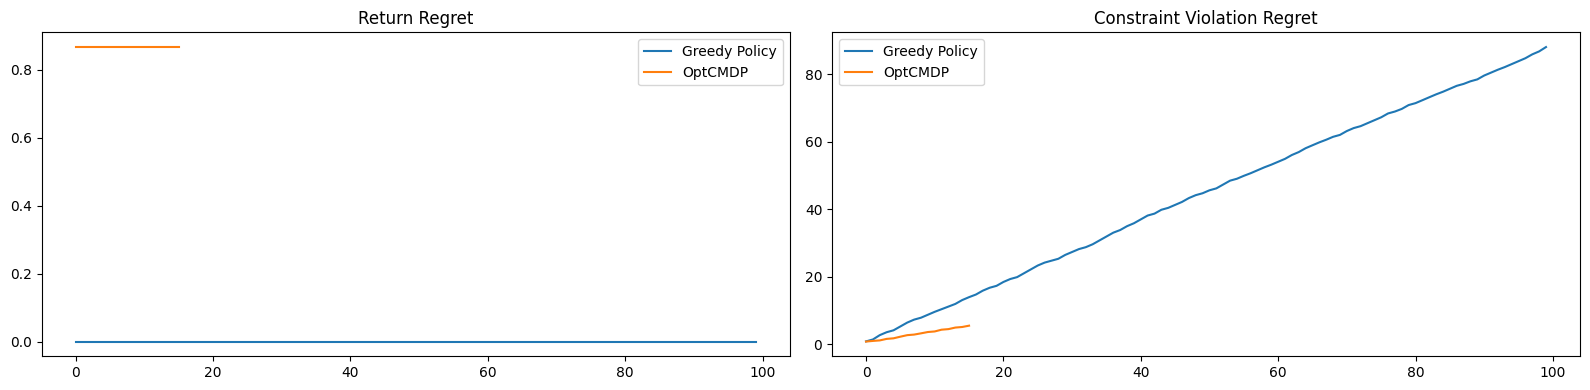

In [62]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.title("Return Regret")
# plt.plot(uni_regrets_rew, label="Uniform Policy")
plt.plot(gr_regrets_rew, label="Greedy Policy")
plt.plot(regrets_rew, label="OptCMDP")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Constraint Violation Regret")
# plt.plot(uni_regrets_vio, label="Uniform Policy")
plt.plot(gr_regrets_vio, label="Greedy Policy")
plt.plot(regrets_vio, label="OptCMDP")
plt.legend()

plt.tight_layout()

途中からNanが出て死んでますが、OptCMDPでは明らかにConstraint Violationが小さくなってますね。